In [1]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2
from trader.utils import *
from trader.tradertk import *

In [2]:
def get_data(file_name):
    stock_data = pd.read_csv(file_name)
    
    # Sort data by date.
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data = stock_data.sort_values(by='Date')
    stock_data.reset_index(drop=True, inplace=True)
    
    sliced_data = stock_data['Open']

    # Just getting returns.
    returns = [0]
    for i in range(1, len(sliced_data)):
        returns.append(sliced_data[i] - sliced_data[i-1])
    
    plt.plot(sliced_data)
    plt.title(file_name)
    plt.xlabel('time')
    plt.show()
    
    return sliced_data, returns


def agent_run(just_data, returns, M, window_size, n_steps, start_position, name='_',
              miu=1, delta=0.0006, num_iter_learn=100, learning_rate_0=0.01, is_dynam_lr=False):
    """
    Start trading using initial parameters.
    
    Parameters
    ----------
    just_data : list
        List of prices.
    returns : list
        List of returns.
    M : int
        The number of time series inputs to the trader.
    window_size : int
        Size of historical window.
    n_steps : int
        Number of steps to make predictions.
    start_position : int
        Start-postion time step.
    name : str
        The name of Stocks (the default in '_').
    miu : float, optinonal
        Maximum possible number of shares per transaction (the default is 1).
    delta : float, optinonal
        (the default is 0.0006, which is used at stocks in Moscow).
    num_iter_learn : int, optinonal
        (the default is 0.01).
    learning_rate_0 : float, optinonal
        Learning rate (the default is 0.01).
    is_dynam_lr : bool, oprional
        Flag to use or not dynamic learning rate (the default is False).
        
    Returns
    -------
    Nothing. It just trades and plots :).
    
    """
    w = np.random.uniform(-0.1, 0.1, M + 3)  # Weights initialization.

    F_predictions = []  # Agent's actions.
    
    # They are both needed for training.
    F_last_value = 0
    F_first_value = 0
    
    # Iterate over time from start_position to start_position + n_steps.
    # Make prediction from 
    for t1 in tqdm.tqdm(range(start_position, start_position+n_steps)):
        t_pred = t1 + window_size
        
        if DYNAM_LR:
            # Dynamic learning rate.
            learning_rate = learning_rate_0 * (n_steps - t1) / n_steps
        else:
            learning_rate = learning_rate_0

        # Training on previous history.
        for _ in range(num_iter_learn):
            X = build_x_matrix(t1, window_size, M, returns, w, F_first_value)
            
            # Just getting last coordinate of vectors from matrix X.
            F = get_trader_func(X)
            
            # Calculate rewards and sharpe.
            Rewards, s_ratio = get_rewards(t1, returns, F, miu, delta)
            
            # Calculate gradient dF/dW.
            dFt = get_grad_F_w(X, w)

            # Calculate gradient dS/dW.
            grad = get_grad_S_w(t1, Rewards, returns, F, miu, delta, dFt)
            
            # Update weights.
            w += learning_rate * grad
        ## End of the training on history.

        F_first_value = F[1]
        F_last_value = F[-1]
        
        # Make prediction for time_step t1 + 1.
        F_predictions.append(trader_function(build_x_vector(t_pred, M, returns, F_last_value), w))
    ## End of iteration from start_position to start_position + n_steps. 


    # Calculate rewards and sharpe on predicted data.
    rewards_predictions, sharp = get_rewards(start_position + window_size, returns, 
                                             np.array(F_predictions), miu, delta)

    # Just calculating the money we've earned [or lost].
    money = [0]
    for i in range(1, len(rewards_predictions)):
        money.append(sum(rewards_predictions[:i]))

        
    # Here goes many plots.
    plt.figure(figsize=(20,10))
    
    # Agent's actions.
    plt.subplot(221)
    plt.plot(F_predictions)
    plt.title('Predicted $F_t$')
    plt.xlabel('time')

    # Rewards.
    plt.subplot(222)
    plt.plot(rewards_predictions)
    plt.title('Predicted Rewards')
    plt.xlabel('time')

    # Stock data.
    plt.subplot(223)
    plt.plot(just_data[start_position + window_size:start_position + window_size + n_steps])
    plt.title(name)
    plt.xlabel('time')

    # Earned [or lost] money.
    plt.subplot(224)
    plt.plot(money)
    plt.title('Money')
    plt.xlabel('time')
    plt.show()
    
    
    # Plot last 20 values.
    plt.plot(F_predictions[-20:])
    plt.title('Predicted $F_t$ - last 20 values')
    plt.xlabel('time')
    plt.show()
    
    plt.plot(money[-20:])
    plt.title('Money - last 20 values')
    plt.xlabel('time')
    plt.show()
    
    plt.plot(just_data[start_position + window_size:start_position + window_size + n_steps][-20:])
    plt.title(name + ' - last 20 values')
    plt.xlabel('time')
    plt.show()

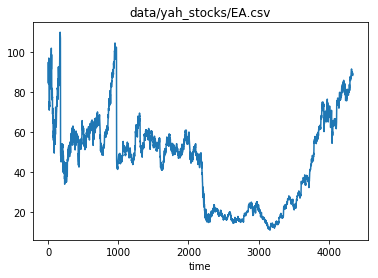

In [3]:
data, returns = get_data('data/yah_stocks/EA.csv')

100%|██████████| 1000/1000 [00:16<00:00, 60.49it/s]


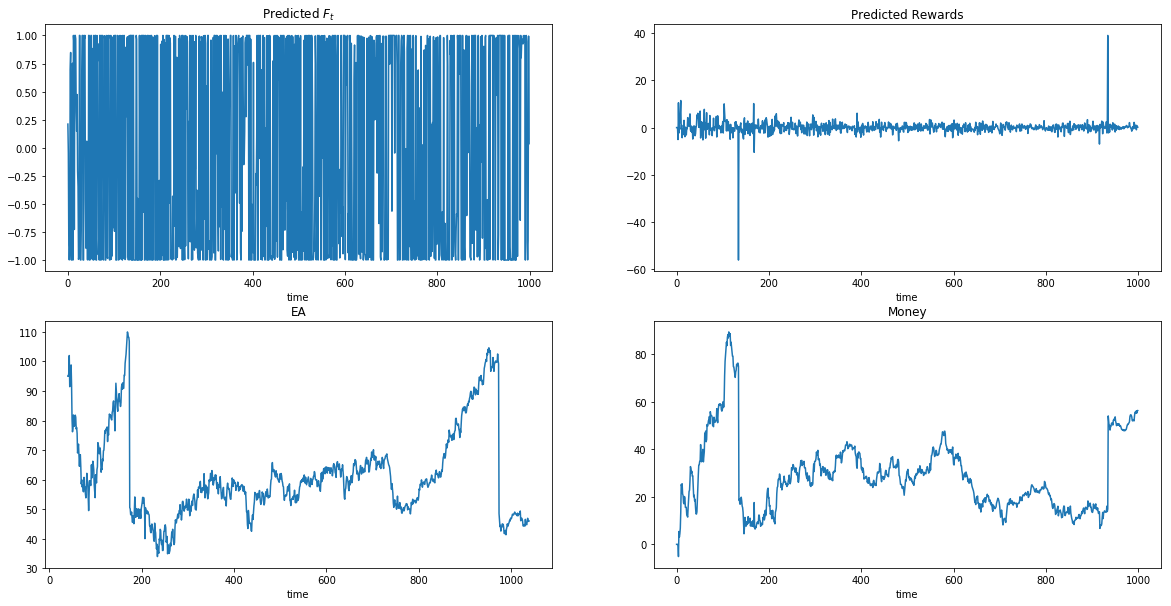

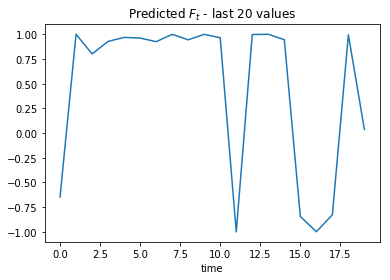

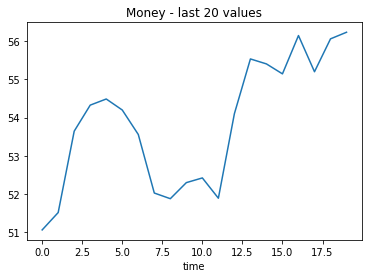

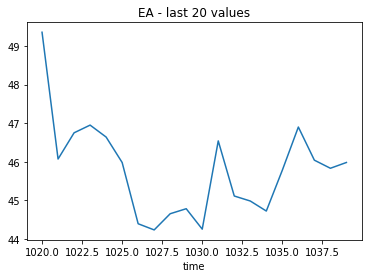

In [4]:
agent_run(data, returns, name='EA', M=39, window_size=40, n_steps=1000, start_position=0, num_iter_learn=10)